In [1]:
# DATA PROCESSING, VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import string
import re

# MODELS, MODEL EVALUATION
from openai import OpenAI
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import os
import json
from typing import List
import requests
import time
from tqdm import tqdm

In [2]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [3]:
%run 0-Function-Helper.ipynb

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

In [5]:
with open("../file_path.txt", 'r') as file:
    file_path = file.read()

with open(file_path, 'r') as file:
    api_key = file.read()

client = OpenAI(
    api_key=api_key,
)

In [6]:
def create_batch_request_to_open_ai_embeddings(
    list_of_texts: List[str],
    name_of_request_file: str,
    description_of_request: str,
    dimensions: int = None,
):
    """Function that creates .jsonl file with appropriate format and then sends call to create embeddings using batches"""
    
    dictionary_req = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/embeddings", 
        "body": {"model": "text-embedding-3-large",
                 "input": f"{prompt}",
                 **({"dimensions": dimensions} if dimensions is not None else {})
                }
    } for i, prompt in enumerate(list_of_texts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary_req:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/embeddings",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )
    

## 1000 dimensions

In [12]:
result_file_name = "batch_result_train_10_11_2024_1000_dimensions"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_train_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df.append(emb)


result_file_name = "batch_result_val_10_11_2024_1000_dimensions"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_val_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df.append(emb)

32000it [00:11, 2825.67it/s]


## Training with baitness score

In [15]:
from measure import baitness_measure

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [16]:
def add_baitness_measure(x_data, x_vect):
    # Compute baitness measure and combine with vectorized data
    baitness_column = x_data.apply(baitness_measure).reset_index(drop=True)
    x_vect_and_bait = pd.DataFrame(x_vect)
    x_vect_and_bait['baitness_value'] = baitness_column.values  # Avoid extra reindexing
    x_vect_and_bait.columns = range(x_vect_and_bait.shape[1])  # Standardize column names
    return x_vect_and_bait

In [17]:
x_vect_and_baitness_measure = add_baitness_measure(x_train, embeddings_x_train_df)
x_val_vect_and_bait = add_baitness_measure(x_val, embeddings_x_val_df)

0.88 & 0.897 & 0.858 & 0.877 & 0.949 \
{'Accuracy': 0.88025, 'Precision': 0.8971668415529905, 'Recall': 0.8580030105368791, 'F1 Score': 0.8771479866632469, 'ROC-AUC': 0.9493562546141191}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2007
           1       0.90      0.86      0.88      1993

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



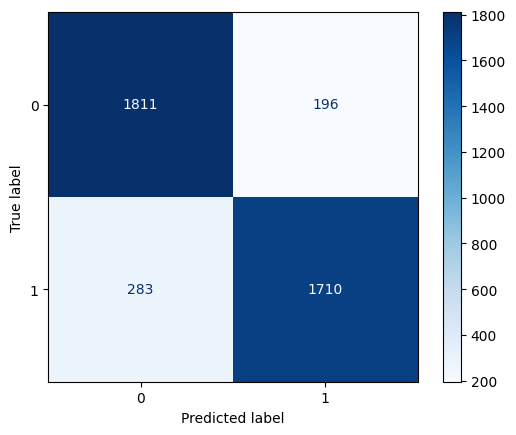

In [18]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_vect_and_baitness_measure, y_train)
pred_rf = RF.predict(x_val_vect_and_bait)
pred_rf_prob = RF.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.886 & 0.887 & 0.882 & 0.885 & 0.954 \
{'Accuracy': 0.8855, 'Precision': 0.8874305906108026, 'Recall': 0.8820873055694932, 'F1 Score': 0.8847508807247108, 'ROC-AUC': 0.9541335631361485}

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2007
           1       0.89      0.88      0.88      1993

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



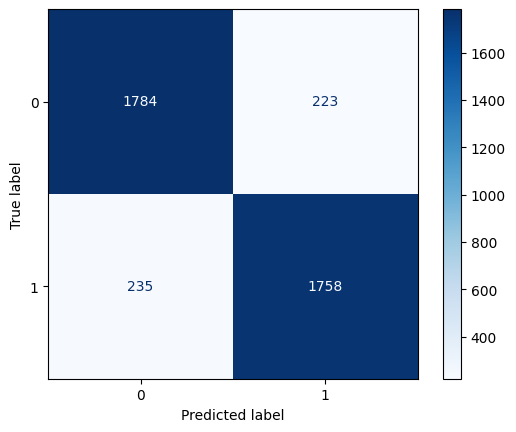

In [19]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_vect_and_baitness_measure, y_train)
pred_xgb = xgb_model.predict(x_val_vect_and_bait)
pred_xgb_prob = xgb_model.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

## 3000 dimensions

In [20]:
result_file_name = "batch_result_train_10_11_2024"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_train_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df.append(emb)


result_file_name = "batch_result_val_10_11_2024"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_val_df = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df.append(emb)

32000it [00:41, 762.17it/s] 
4000it [00:04, 969.93it/s]


In [21]:
x_vect_and_baitness_measure = add_baitness_measure(x_train, embeddings_x_train_df)
x_val_vect_and_bait = add_baitness_measure(x_val, embeddings_x_val_df)

0.878 & 0.897 & 0.851 & 0.874 & 0.949 \
{'Accuracy': 0.8775, 'Precision': 0.8974087784241143, 'Recall': 0.8514801806322128, 'F1 Score': 0.8738414006179197, 'ROC-AUC': 0.9485984953315679}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2007
           1       0.90      0.85      0.87      1993

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



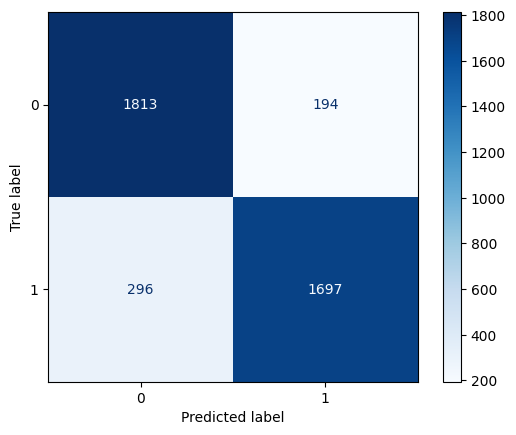

In [22]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_vect_and_baitness_measure, y_train)
pred_rf = RF.predict(x_val_vect_and_bait)
pred_rf_prob = RF.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.889 & 0.895 & 0.881 & 0.888 & 0.957 \
{'Accuracy': 0.889, 'Precision': 0.8945491594498217, 'Recall': 0.8810837932764677, 'F1 Score': 0.8877654196157736, 'ROC-AUC': 0.9572529763489603}

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2007
           1       0.89      0.88      0.89      1993

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



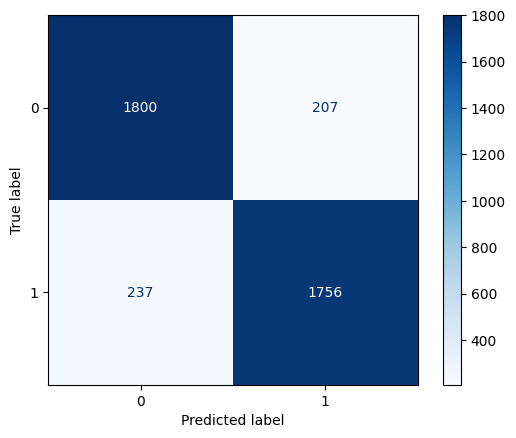

In [23]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_vect_and_baitness_measure, y_train)
pred_xgb = xgb_model.predict(x_val_vect_and_bait)
pred_xgb_prob = xgb_model.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

## Training with multiple informativeness measures